<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/LSTM_seq_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM model for time series prediction for the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world. https://github.com/YunzhanZHOU/EDVAM

**The Problem:**

We redefine the original problem from a classification task to a regression task. We condiser the following 9 features:


*   3D point of gaze (PoG) [X, Y, Z] - 3 features.
*   Camera position [X, Y, Z] - 3 features.
*   Camera orientation vector [X, Y, Z] - 3 features.

We consider a frame as a 9-tuple of real values for each of these features. Using the EDVAM dataset which consists of time sequences of these frames collected from 63 participants, we train an LSTM model to predict the next frame from a sequence of n past frames.

The goal of this is to acheive a more refined prediction for subsequent visual attention and user orientation.








**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install Dependencies**

In [ ]:
!pip install livelossplot

**Imports**

In [3]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyper-params**

In [4]:
BATCH_SIZE = 128
LR = 0.001
N_EPOCH = 30

NUM_FEATURES = 9
HIDDEN_DIM = 100
NUM_LAYERS = 2

SEQ_LEN = 300

**Construct the Dataset**

Using the EDVAM raw subset we construct training examples. Using a sliding window of 10 seconds (300 frames) we generate sequences of frames as training examples, the targets for our training examples are the subsequent frames.

In [5]:
dataset = []

# read in data from the raw EDVAM dataset
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/EDVAM_raw_subset/'+str(num)+'.csv', header=0)).iloc[:,2:11]))

train_set = []
train_targets = []

test_set = []
test_targets = []

test_ids = [54, 40, 38, 52, 62, 58, 46, 12, 24]

for num in range(0, 63):
  if num not in test_ids:
    train_set.extend([np.array(dataset[num][i:i+SEQ_LEN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN)])
    train_targets.extend([np.array(dataset[num][i+SEQ_LEN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN)])

  else:
    test_set.extend([np.array(dataset[num][i:i+SEQ_LEN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN)])
    test_targets.extend([np.array(dataset[num][i+SEQ_LEN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN)])

train_set = np.array(train_set)
train_targets = np.array(train_targets)

test_set = np.array(test_set)
test_targets = np.array(test_targets)

**Visualizing Time Sequences**

Let's visualize some time sequences from the test data by plotting them on 3D axes. 

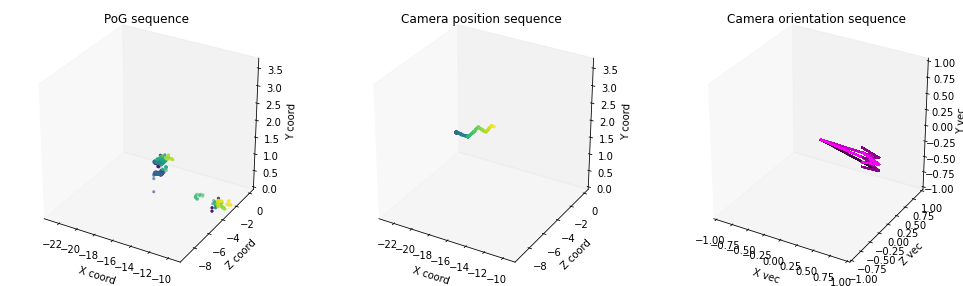

In [6]:
def plot_seq(arr): # requires non-normalized data
  seq_len = arr.shape[0]

  # PoG (x, y, z)
  x_p = arr[:, 0]
  y_p = arr[:, 1]
  z_p = arr[:, 2]

  # Camera pos (x, y, z)
  x_c = arr[:, 3]
  y_c = arr[:, 4]
  z_c = arr[:, 5]

  # Camera vec (x, y, z)
  x_o = arr[:, 6]
  y_o = arr[:, 7]
  z_o = arr[:, 8]
  
  fig = plt.figure(figsize=(17, 5))

  ax = fig.add_subplot(1,3,1, projection='3d')

  ax.set_title("PoG sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_p,z_p,y_p, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,2, projection='3d')

  ax.set_title("Camera position sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_c,z_c,y_c, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,3, projection='3d')

  ax.set_title("Camera orientation sequence")
  ax.set_xlabel("X vec")
  ax.set_ylabel("Z vec")
  ax.set_zlabel("Y vec")

  ax.set_xlim(-1, 1)
  ax.set_zlim(-1,1)
  ax.set_ylim(-1,1)

  ax.grid(False)
  # visualize camera orientations as unit vectors
  ax.quiver(np.zeros_like(90,), np.zeros_like(90,), np.zeros_like(90,), x_o, y_o, z_o, 
            colors=[(col, 0, col) for col in np.arange(0,1.0,step=(1/seq_len))])

  plt.show()

idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN)

plot_seq(np.array([dataset[idx][start+i, :] for i in range(SEQ_LEN)]))

**Normalize the Data**

We normalize the data so that no feature takes priority over the other when training the network.

In [7]:
means = np.array([[[-14.36113819,   1.6289878,   -4.3960396,  -16.36456295,   1.71260748,
                     -4.05706022,   0.49849881,  -0.03998035,  -0.03879195]]], dtype=np.float32)

stds = np.array([[[4.03698547, 0.8635303,  2.79440592, 2.69018196, 0.06613871, 1.5993084,
                   0.65815014, 0.17796627, 0.54445267]]], dtype=np.float32)

 # normalize both datasets using pre-computed means and stds
train_set = (train_set - means) / stds
train_targets = (train_targets - np.squeeze(means, 0)) / np.squeeze(stds, 0)

test_set = (test_set - means) / stds
test_targets = (test_targets - np.squeeze(means, 0)) /np.squeeze(stds, 0)

**Setup the Dataloaders**

In [8]:
# wrap data in tensors and init data loaders
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_targets))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_targets))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_iter = iter(cycle(test_loader))

**Define the Model**

The model we use is an LSTM-style recurrent neural network with and additional linear layer to decode the hidden state of the LSTM to 9-tuple of real values that represent the next frame.

The best parameters that we found are as follows:


*   Hidden size = 100
*   Number of LSTM layers = 2
*   Dropout = 0.0









In [9]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim, num_layers, dropout=0):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, dropout=dropout, batch_first=True)
    self.decoder = nn.Linear(hidden_dim, output_size)

    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    # init the weights of the linear layer
    initrange = 0.1
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    for names in self.lstm._all_weights:
      for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(self.lstm, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True) 
    self.c0 = nn.Parameter(c0, requires_grad=True)

  def forward(self, input, future=1):
    outputs = []
    input = input.float()
    batch_size = input.shape[0]

    # initial hidden state 
    hidden = (self.h0.repeat(1, batch_size, 1), self.c0.repeat(1, batch_size, 1))

    lstm_out, hidden = self.lstm(input, hidden)
    output = self.decoder(lstm_out[:, -1]).unsqueeze(1)
    outputs += [output]

    for i in range(future-1):
      lstm_out, hidden = self.lstm(output, hidden)
      output = self.decoder(lstm_out)
      outputs += [output]

    outputs = torch.stack(outputs, 1).squeeze(2)
    return outputs

input_size = NUM_FEATURES
output_size = NUM_FEATURES

model = LSTMModel(input_size, output_size, HIDDEN_DIM, NUM_LAYERS).to(device)
optim = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True) # SGD gives us poor convergence
liveplot = PlotLosses()

**Training Code**

We will train the model as expected - using mini-batch SGD (using Adam optimizer instead) and minimizing the MSE loss between the predicted next frame and the ground truth.

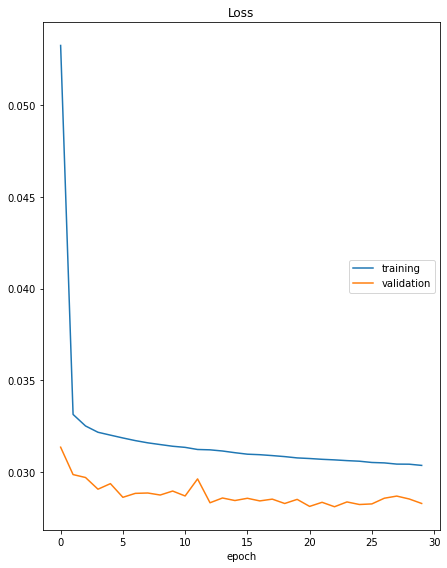

Loss
	training         	 (min:    0.030, max:    0.053, cur:    0.030)
	validation       	 (min:    0.028, max:    0.031, cur:    0.028)
Epoch 30/30, train_loss: 0.030362, val_loss: 0.028286, best_val_loss: 0.028107, best_epoch: 23


In [10]:
step = 0
best_val_loss = np.inf
best_epoch = 0

while (step < N_EPOCH):

  loss_arr = np.zeros(0)
  val_loss_arr = np.zeros(0)

  model.train()
  
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    outputs = outputs.squeeze()

    loss = nn.MSELoss()(outputs, targets)

    # parameter update step
    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_arr = np.append(loss_arr, loss.item())

  model.eval()

  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      outputs = outputs.squeeze()

      val_loss = nn.MSELoss()(outputs, targets) 

      val_loss_arr = np.append(val_loss_arr, val_loss.item())

  step += 1

  val_losses = val_loss_arr.mean()
  train_losses = loss_arr.mean()

  if val_losses < best_val_loss:
    best_epoch = step
    best_val_loss = val_losses
    torch.save({'model':model.state_dict()}, 'drive/My Drive/training/LSTM_pred.chkpt')

  liveplot.update({"loss" : train_losses, "val_loss" : val_losses})
  liveplot.send()

  print('Epoch {}/{}, train_loss: {:.6f}, val_loss: {:.6f}, best_val_loss: {:.6f}, best_epoch: {}'.format(step, N_EPOCH, train_losses,val_losses, best_val_loss, best_epoch))

**Model Validation**

Let's load out best model and see how well it does on unseen data.

In [11]:
try:
  params = torch.load('drive/My Drive/training/LSTM_pred.chkpt')
  model.load_state_dict(params['model'])
except:
  print('Failed to load best model ... using current model')

model.eval()

val_loss_arr = np.zeros(0)

with torch.no_grad():
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    outputs = outputs.squeeze()

    val_loss = nn.MSELoss()(outputs, targets)

    val_loss_arr = np.append(val_loss_arr, val_loss.item())

print('val loss {:.6f}'.format(val_loss_arr.mean()))

val loss 0.028107


# Evaluate the model

Let's have a look at some regression metrics and accuracy scores for each of the features.

In [12]:
model.eval()

futures = [1, 5, 10, 45, 90] # how good is the model at predicting into the future

df_m = pd.DataFrame(index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
df_p = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_c = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_v = pd.DataFrame(index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])

for future in futures:
  actual, predicted = [], []

  with torch.no_grad():
    for idx in test_ids:
      for start in range(0, dataset[idx].shape[0] - SEQ_LEN - BATCH_SIZE - future, BATCH_SIZE):

        inputs = np.array([np.array(dataset[idx][start+i:start+i+SEQ_LEN, :], dtype=np.float32) for i in range(BATCH_SIZE)])
        targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN+future-1, :], dtype=np.float32)for i in range(BATCH_SIZE)])
        
        # transform input
        inputs = (inputs - means) / stds
        inputs = torch.tensor(inputs).to(device)

        outputs = model(inputs, future=future)

        outputs = outputs[:, -1].data.cpu().numpy()

        # inverse transform output
        predicted += (outputs * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)).tolist()

        actual += targets.tolist()

  actual, predicted = np.array(actual), np.array(predicted)

  N = actual.shape[0]

  # point of gaze accuracy measures (in meters)
  pog_error = np.sqrt(np.square(actual - predicted)[:, 0:3].sum(axis=1))
  pog_accuracy = [100 * np.array([1 if error < dist else 0 for error in pog_error]).sum() / N for dist in [.5, 1., 2., 5.]]

  # camera position accuracy measures (in meters)
  cam_error = np.sqrt(np.square(actual - predicted)[:, 3:6].sum(axis=1))
  cam_accuracy = [100 * np.array([1 if error < dist else 0 for error in cam_error]).sum() / N  for dist in [.5, 1., 2., 5.]]

  # camera orientation error (in degrees)
  vec_error = np.arccos((actual[:, 6] * predicted[:, 6] + actual[:, 7] * predicted[:, 7] + actual[:, 8] * predicted[:, 8])
              / (np.sqrt(actual[:, 6]**2 + actual[:, 7]**2 + actual[:, 8]**2) * np.sqrt(predicted[:, 6]**2 + predicted[:, 7]**2 + predicted[:, 8]**2)))
  # convert from radians to degrees
  vec_error = vec_error * 180 / np.pi
  vec_error = [100 * np.array([1 if error < angle else 0 for error in vec_error]).sum() / N  for angle in [1., 5., 10., 30.]]

  # regression metrics
  MSE = (np.square(actual - predicted)).mean(axis=0) # mean squared error
  MAE = (np.abs(actual - predicted)).mean(axis=0) # mean absolute error
                    
  # adjusted R squared correlation coeff for multiple regression
  # each feature is dependent on each feature, but some features are correlated
  N = predicted.shape[0]
  k = predicted.shape[1]
  adj_R2 = []
  corr_matrix = np.corrcoef(predicted, rowvar=False)
  for i in range(k):
    corr_yi = np.corrcoef(predicted, actual[:, i], rowvar=False)
    corr_vec = [corr_yi[j][9] for j in range(k)]

    R2 = np.dot(np.dot(corr_vec, np.linalg.inv(corr_matrix)), corr_vec)

    adj_R2 += [1 - (1 - R2)*((N - 1) / (N - k - 1))]

  df = pd.DataFrame({"MSE" : MSE, "MAE" : MAE, "adj R2" : adj_R2}, 
                    index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
  df_m = pd.concat([df_m, df], axis=1)

  df = pd.DataFrame({"PoG accuracy" : pog_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_p = pd.concat([df_p, df], axis=1)

  df = pd.DataFrame({"Camera accuracy": cam_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_c = pd.concat([df_c, df], axis=1)

  df = pd.DataFrame({"Camera vec accuracy" : vec_error}, index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])
  df_v = pd.concat([df_v, df], axis=1)

**Model prediction metrics**

In [13]:
pd.set_option("display.precision", 5)
df_m.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['MSE', 'MAE', 'R2']])
display(df_m)

1 futures                    ... 90 futures                  
                MSE      MAE       R2  ...        MSE      MAE       R2
PoG X       0.71393  0.38115  0.96550  ...   36.36271  4.68496  0.28087
PoG Y       0.11824  0.15726  0.87537  ...    1.16946  0.84612  0.15714
PoG Z       0.26983  0.24346  0.97017  ...   10.18285  2.40818  0.32790
Cam X       0.00369  0.04344  0.99965  ...   15.45370  3.30538  0.42252
Cam Y       0.00003  0.00112  0.91226  ...    0.00849  0.06719  0.02963
Cam Z       0.00160  0.02673  0.99954  ...    4.07758  1.58318  0.35525
Cam Vec X   0.00053  0.01360  0.99911  ...    0.65219  0.61175  0.25755
Cam Vec Y   0.00019  0.00510  0.99377  ...    0.10971  0.26524  0.21860
Cam Vec Z   0.00050  0.01218  0.99868  ...    0.34632  0.44144  0.31026

[9 rows x 15 columns]

**Model prediction accuracy for PoG in 3D world coordinates**

In [14]:
pd.set_option("display.precision", 2)
df_p.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['PoG accuracy']])
display(df_p)

,1 futures,5 futures,10 futures,45 futures,90 futures
,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy
<.5m,74.08,16.82,4.61,0.33,0.34
<1m,87.67,56.16,25.32,3.49,1.51
<2m,94.90,85.80,69.70,17.55,8.63
<5m,98.81,98.02,96.97,68.71,52.04


**Model prediction accuracy for Camera position in 3D world coordinates**

In [15]:
df_c.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera position accuracy']])
display(df_c)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy
<.5m,99.98,97.08,70.36,4.32,2.08
<1m,100.00,99.97,96.70,16.91,6.75
<2m,100.00,100.00,99.99,46.72,21.49
<5m,100.00,100.00,100.00,97.67,70.53


**Model prediction accuracy for 3D camera orientation**

In [16]:
df_v.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera vec accuracy']])
display(df_v)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy
<1 deg,76.42,14.30,3.58,0.11,0.05
<5 deg,95.42,73.52,40.48,3.93,1.20
<10 deg,99.99,95.20,75.59,15.26,5.43
<30 deg,100.00,100.00,99.24,55.32,33.71


# Having a closer look

It's clear that our model has excellent next frame prediction (0 futures), however it does make some mistakes, and these errors compound very quickly over time and the model fails drastically at predicting the frame 100 timesteps into the future. Let's have a closer look at what is going on.

**Using the Future:**

Let's give the model the ability to look into the future and see what happens. The following code passes 300 frames through the LSTM model and predicts a further 10 frames into the future (using its own output as input). It does this for 300 sequences (of 300 frames) time-shifted by 1 to generate a sequence of future predictions. 

We also fetch the ground truth from the dataset (frames 310 to 610) and compare the sequences visually. 

In [17]:
future = 10

# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN*2 - 1 - future)

inputs = np.array([np.array(dataset[idx][start+i:start+i+SEQ_LEN, :], dtype=np.float32) for i in range(SEQ_LEN)])
targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN+future, :], dtype=np.float32)for i in range(SEQ_LEN)])

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs = model(inputs, future=future)

predicted = outputs[:, -1].data.cpu().numpy() # we only care about the last frame prediction
actual = targets

# inverse transform output
predicted = predicted * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

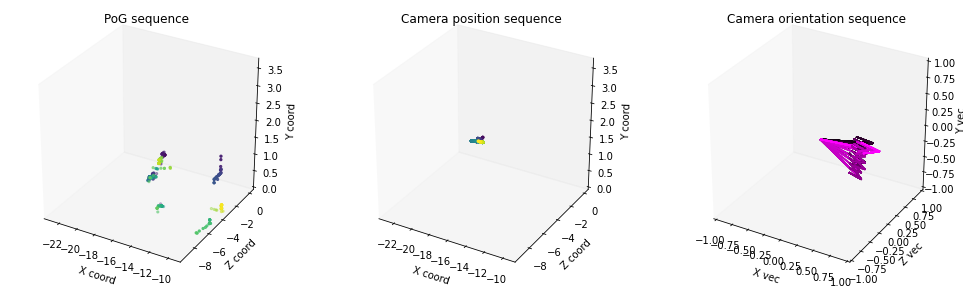

In [18]:
plot_seq(actual)

Future prediction:

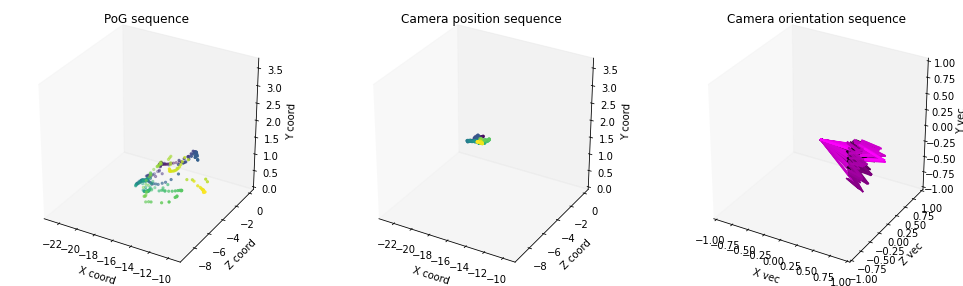

In [19]:
plot_seq(predicted)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the predicted sequence for each of the 9 features, if the graphs line up then our model can successfully predict short term changes.

PoG X:

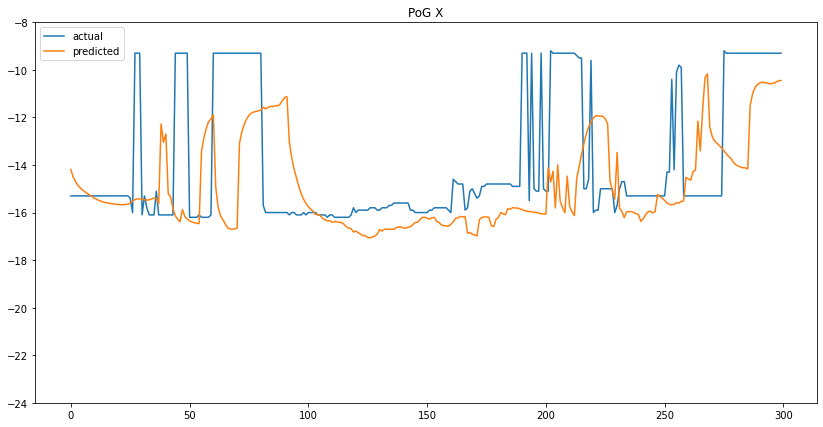

In [20]:
df = pd.DataFrame({"actual" : actual[:,0].tolist(), "predicted" : predicted[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

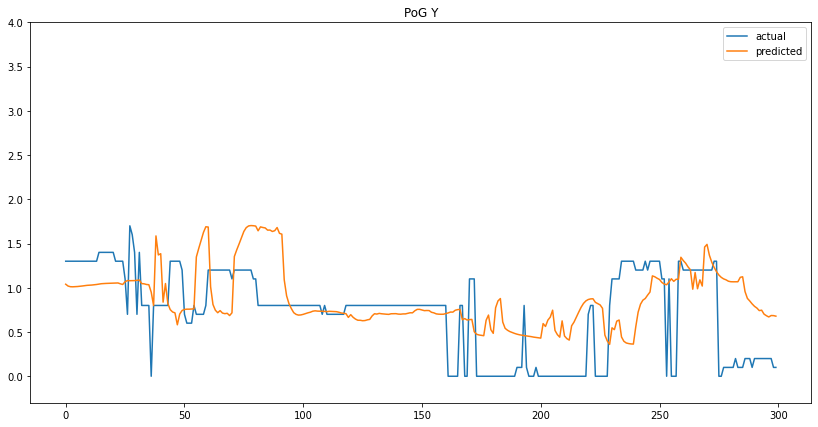

In [21]:
df = pd.DataFrame({"actual" : actual[:,1].tolist(), "predicted" : predicted[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

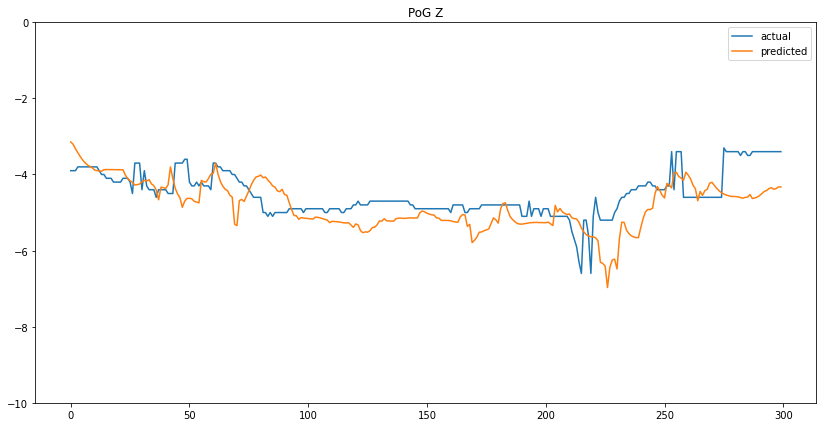

In [22]:
df = pd.DataFrame({"actual" : actual[:,2].tolist(), "predicted" : predicted[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,0), title="PoG Z")

Camera position X:

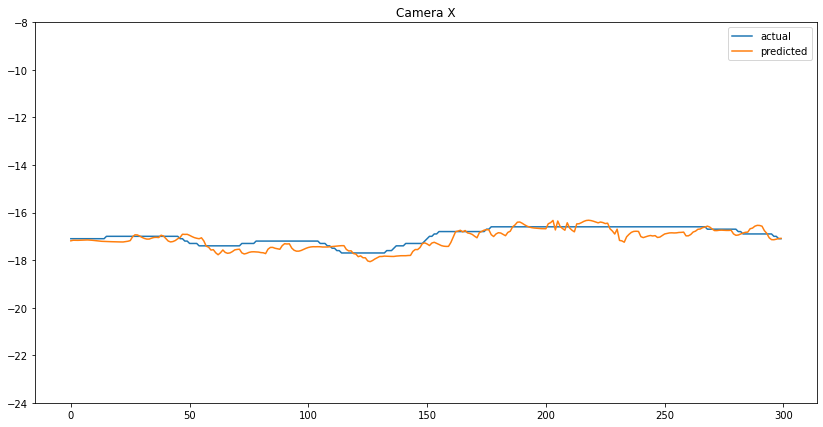

In [23]:
df = pd.DataFrame({"actual" : actual[:,3].tolist(), "predicted" : predicted[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera position Y:

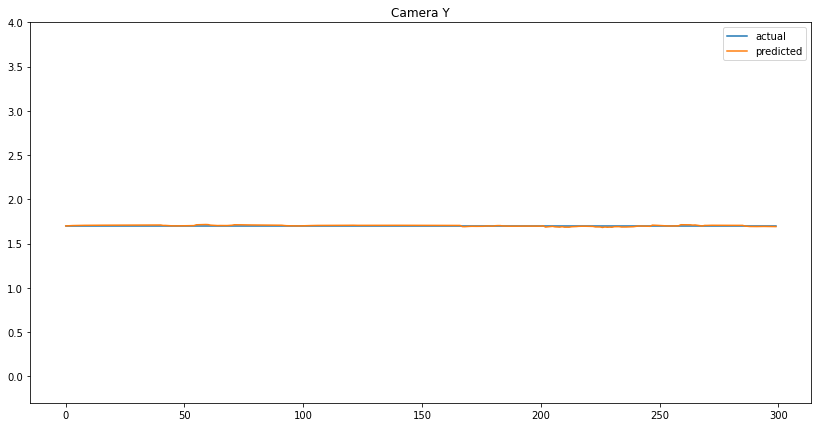

In [24]:
df = pd.DataFrame({"actual" : actual[:,4].tolist(), "predicted" : predicted[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

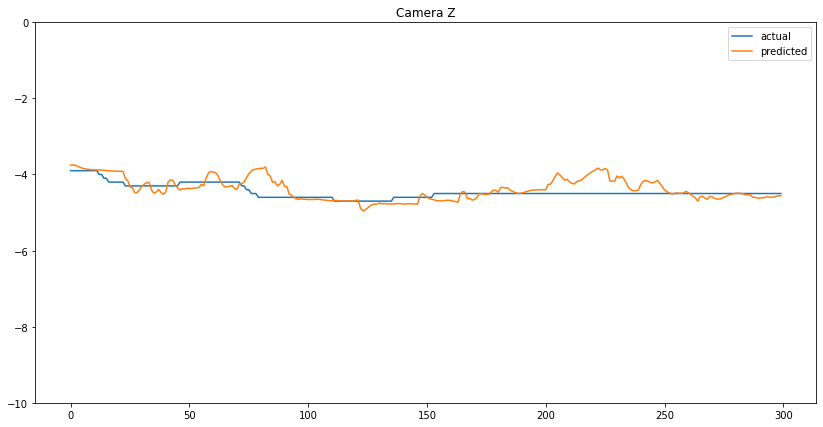

In [25]:
df = pd.DataFrame({"actual" : actual[:,5].tolist(), "predicted" : predicted[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,0), title="Camera Z")

Camera Vector X:

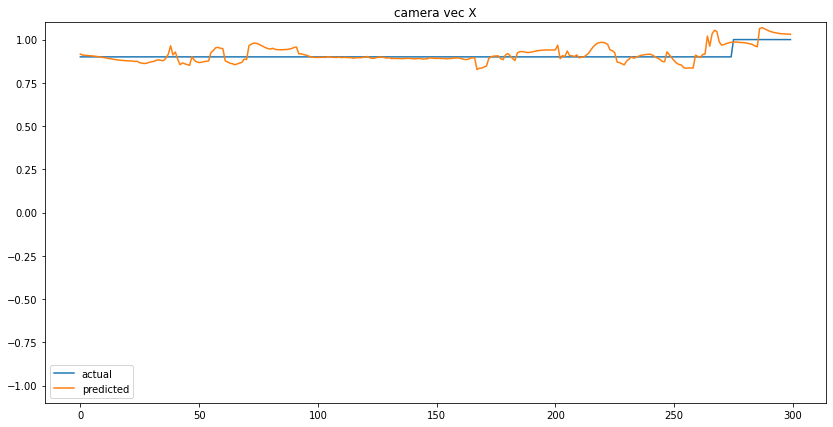

In [26]:
df = pd.DataFrame({"actual" : actual[:,6].tolist(), "predicted" : predicted[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec X")

Camera Vector Y:

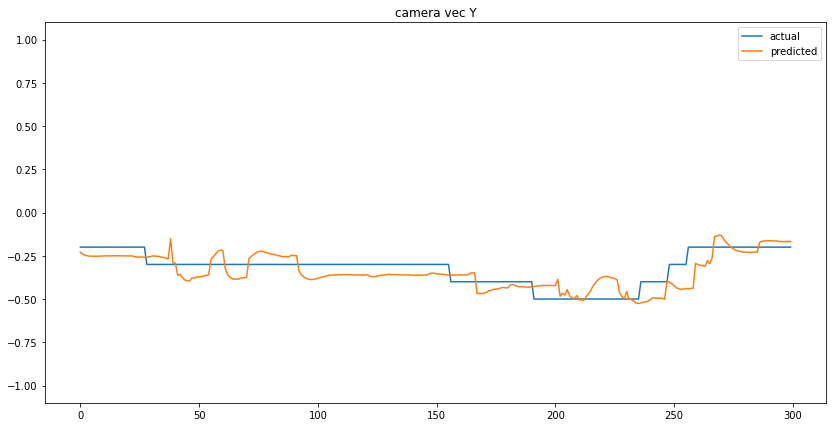

In [27]:
df = pd.DataFrame({"actual" : actual[:,7].tolist(), "predicted" : predicted[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec Y")

Camera Vector Z:

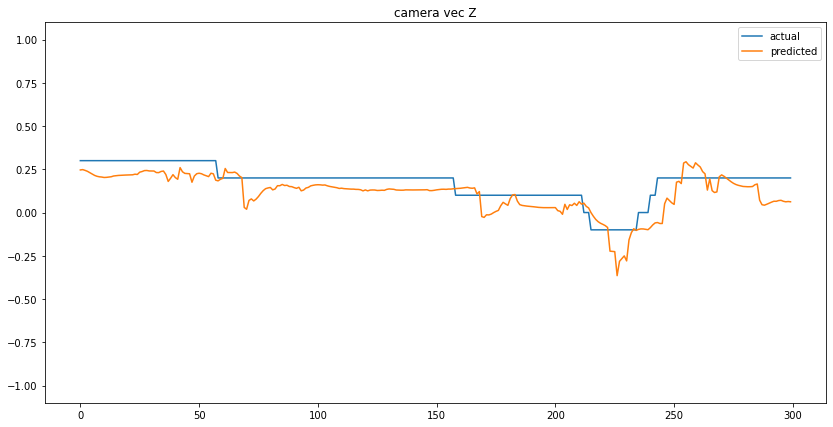

In [28]:
df = pd.DataFrame({"actual" : actual[:,8].tolist(), "predicted" : predicted[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="camera vec Z")

**Some obseravtions:**

By looking at the line graphs we can see that the models predictions fit well to the actual sequences. This is unfortunately not the whole story - because we gave the model the ability to predict 10 time steps into the future ideally we want the model to be able to predict changes before they happen (the graphs would line up in this case). 

If you look closely at the graphs you can see the model almost "lags" behind when trying to predict short term variations and changes. For all we know the model could just be taking the current input and outputting similar values, so maybe it has learnt to just reproduce its inputs.

Next we will look at the model's ability to predict long term trends and changes.

# Sequence Generation

Using the model let's generate a sequence of 90 frames (3 seconds) into the future and see if it has learned longer term dependencies / patterns. 

The following code takes a sequence of 300 frames from the test data passes it through the LSTM and generates 90 more frames into the future (using its output as input).

In [51]:
future = 90

# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN*2 - future - 1)

inputs = np.array(dataset[idx][start:start+SEQ_LEN, :], dtype=np.float32)
targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN+future, :], dtype=np.float32)for i in range(future)])

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs = model(inputs, future=future)

gen_seq = outputs.squeeze(0).data.cpu().numpy()

actual_seq = targets

# inverse transform the generated sequence
gen_seq = gen_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

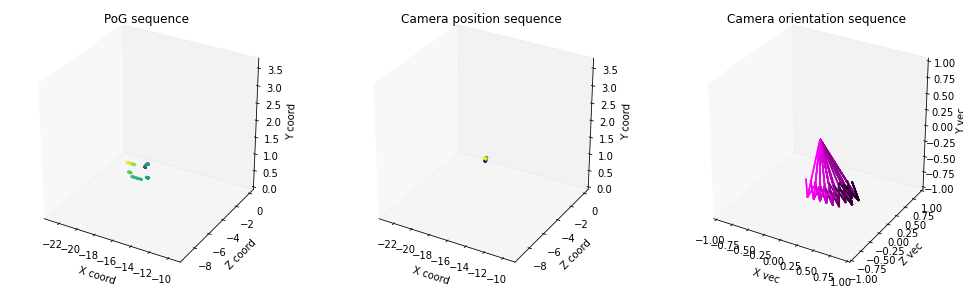

In [52]:
plot_seq(actual_seq)

Generated sequence:

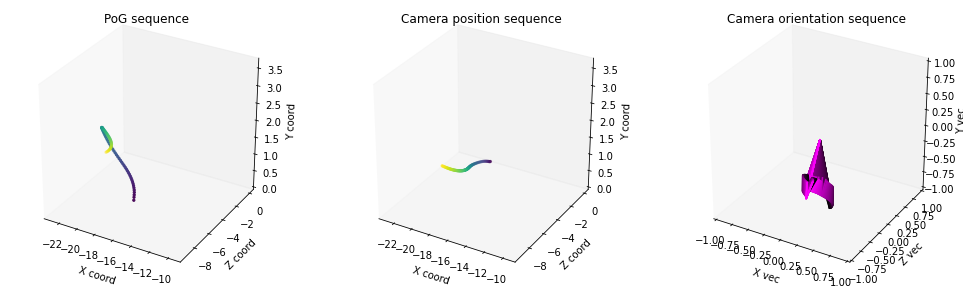

In [53]:
plot_seq(gen_seq)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the generated sequence for each of the 9 features and see if we got close.

PoG X:

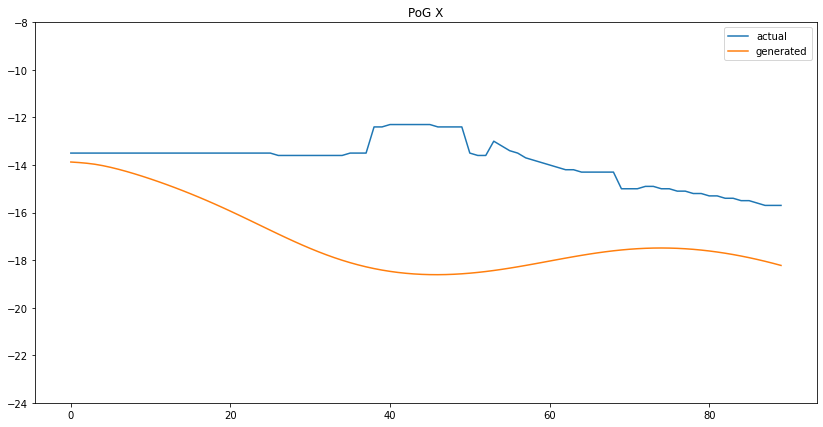

In [54]:
df = pd.DataFrame({"actual" : actual_seq[:,0].tolist(), "generated" : gen_seq[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

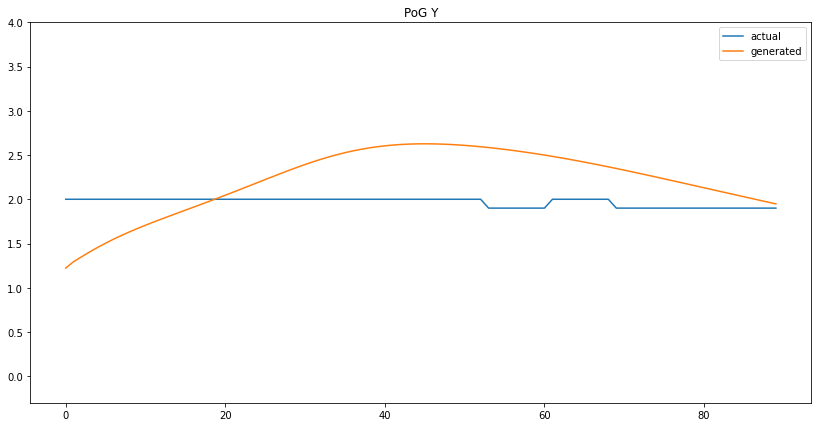

In [55]:
df = pd.DataFrame({"actual" : actual_seq[:,1].tolist(), "generated" : gen_seq[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

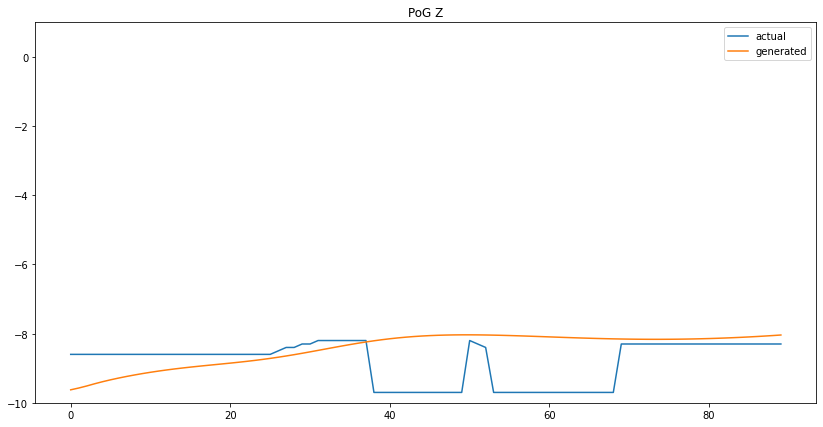

In [56]:
df = pd.DataFrame({"actual" : actual_seq[:,2].tolist(), "generated" : gen_seq[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="PoG Z")

Camera Position X:

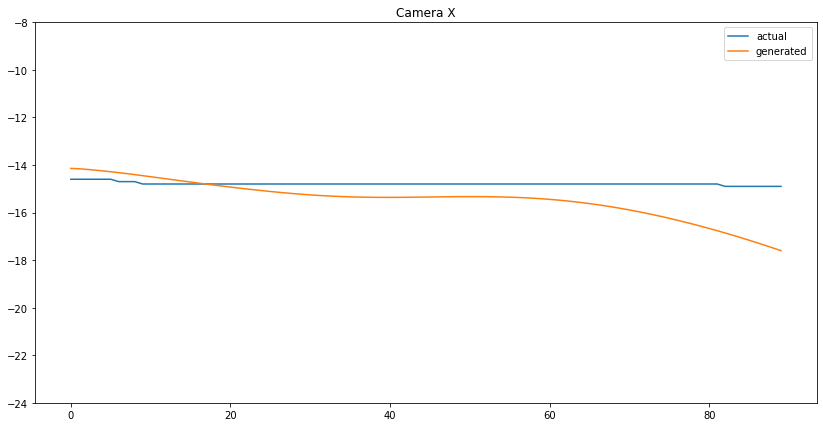

In [57]:
df = pd.DataFrame({"actual" : actual_seq[:,3].tolist(), "generated" : gen_seq[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera Position Y:

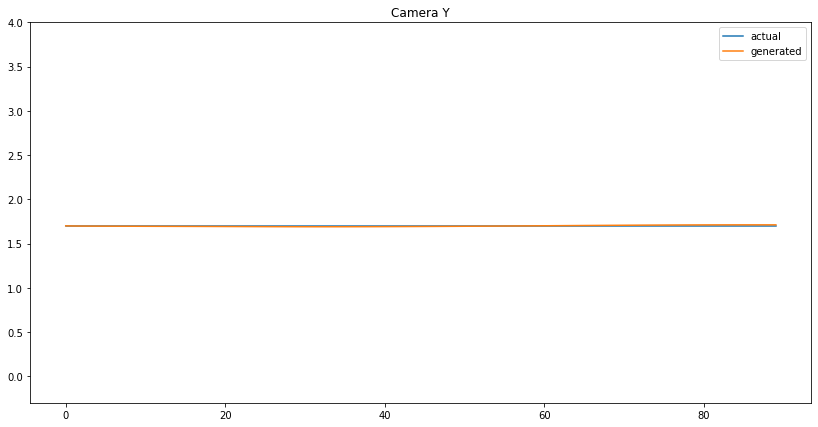

In [58]:
df = pd.DataFrame({"actual" : actual_seq[:,4].tolist(), "generated" : gen_seq[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

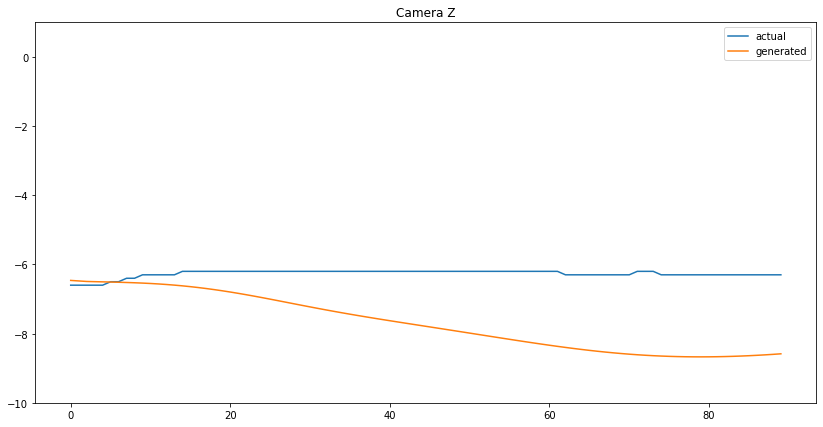

In [59]:
df = pd.DataFrame({"actual" : actual_seq[:,5].tolist(), "generated" : gen_seq[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="Camera Z")

Camera Vector X:

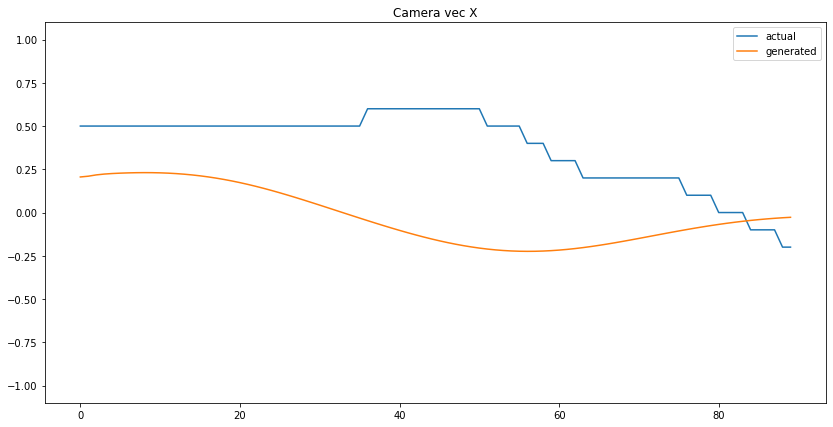

In [60]:
df = pd.DataFrame({"actual" : actual_seq[:,6].tolist(), "generated" : gen_seq[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec X")

Camera Vector Y:

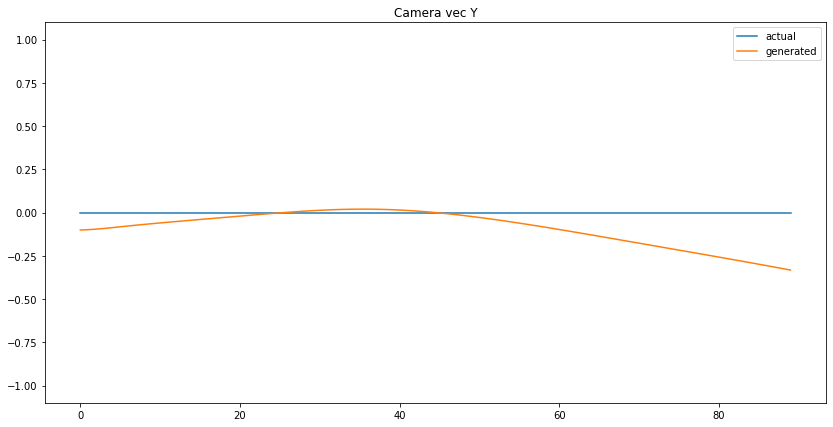

In [61]:
df = pd.DataFrame({"actual" : actual_seq[:,7].tolist(), "generated" : gen_seq[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Y")

Camera Vector Z:

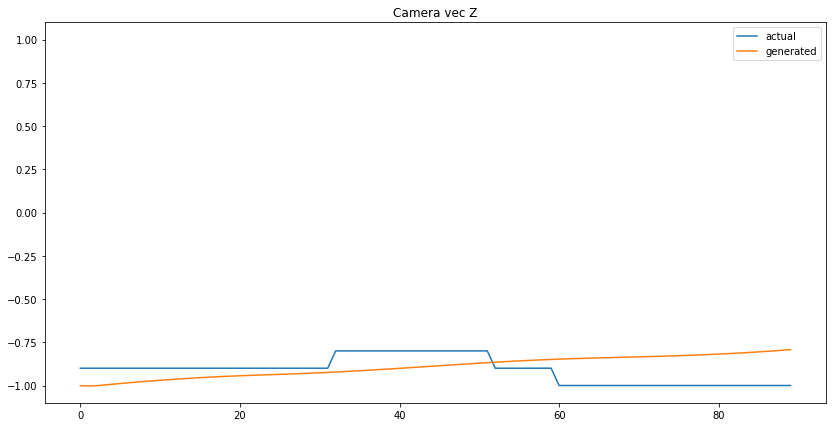

In [62]:
df = pd.DataFrame({"actual" : actual_seq[:,8].tolist(), "generated" : gen_seq[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Z")

**Some obseravtions:**


It is clear that the model fails to predict accurate long term trends into the future. This is not really a surprise because we only trained our model to predict the next frame and did nothing to encourage it to have good sequence generation properties.

# Extensions

*   Use the Encoder-Decoder seq2seq model architecture which has been successful for NLP and image captioning tasks.
*   Use "Professor Forcing" a method for training seq2seq RNNs based on the GAN framework.
*   Investigate "Attention" mechanisms for Encoder-Decoder model architectures.
*   Investigate using Reinforcement Learning to improve pre-trained Encoder-Decoder model architectures.



